In [2]:
from phasenet.model import PhaseNet
from phasenet.zernike import ZernikeWavefront
from csbdeep.utils import normalize, download_and_extract_zip_file
import matplotlib.pyplot as plt
from pathlib import Path
from tifffile import imread
import numpy as np

## Load model

In [3]:
download_and_extract_zip_file (
    url       = 'https://github.com/mpicbg-csbd/phasenet/releases/download/0.1.0/single_mode_model.zip',
    targetdir = 'models',
    verbose   = 1,
)

Files found, nothing to download.


In [4]:
model = PhaseNet(None, name='06_07_2020_17_44_08_oxford_32planes_gpu', basedir='models')

Loading network weights from 'weights_best.h5'.


## Load Data

In [5]:
download_and_extract_zip_file (
    url       = 'https://github.com/mpicbg-csbd/phasenet/releases/download/0.1.0/single_mode_data.zip',
    targetdir = 'data',
    verbose   = 1,
)

Files found, nothing to download.


In [6]:
# Zernike mode number in Noll order
mode_num=5

In [7]:
data_path = Path(f'data/single_mode_data/mode{mode_num}/')

In [8]:
files = sorted((data_path/'images').glob('*.tif'))
images = { f.stem: imread(str(f)) for f in files }

In [9]:
print(images['-0.006'].shape)

(32, 32, 32)





## Predict

In [10]:
accepted_shape = model.keras_model.input_shape[1:-1]
# zerns_ansi = [3,5,6,7,8,9,10,11,12,13,14]
zerns_noll_in_ansi_sorted = [5,6,9,7,8,10,15,13,11,12,14]
def predict(data):
    assert data.shape == accepted_shape, "Image shape and input shape not same"
    data = np.expand_dims(normalize(data),axis=-1)
    return dict(zip(zerns_noll_in_ansi_sorted,model.predict(data)))
random_mode_result = { name:predict(img) for name,img in images.items() }

## Comparision with ground truth

#### Load GT

In [11]:
zerns_noll = [5,6,7,8,9,10,11,12,13,14,15]
gt = np.zeros((len(files),len(zerns_noll)))
gt[:,zerns_noll.index(mode_num)] = [float(f.stem) for f in files]
if mode_num in [7,10,11,14,15]:
    gt = -1*gt
random_mode_gt = { f.stem: dict(zip(zerns_noll,gt[i])) for i,f in enumerate(files) }

#### Plot

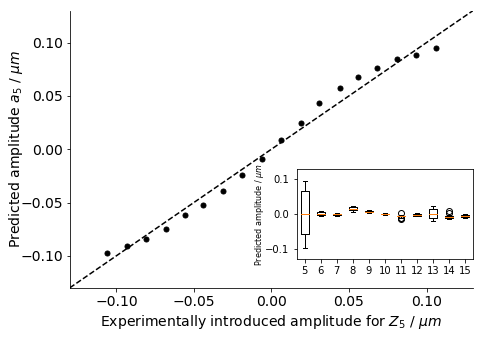

In [14]:
lower_limit,upper_limit = -0.13,0.13

fig = plt.figure(figsize=(7, 5))
ax = fig.add_axes((0.14, .12, .8, .77))

for key,value in random_mode_result.items():
    ax.plot(random_mode_gt[key][mode_num],value[mode_num],"o",color="k", markersize=5)
    
plt.xlabel(f'Experimentally introduced amplitude for $Z_{{{mode_num}}}$ / $\mu m$' , size=14, labelpad=4)
plt.ylabel(f'Predicted amplitude $a_{{{mode_num}}}$ / $\mu m$', size=14, labelpad=-5)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.yticks(size=14)
plt.xticks(size=14)
plt.ylim(lower_limit,upper_limit)
plt.xlim(lower_limit,upper_limit)

X = np.linspace(lower_limit, upper_limit, num=50)
Y = 1 * X
ax.plot(X, Y, ls="--", color = "k")


ax_1 = fig.add_axes([0.59, 0.20, 0.35, 0.25])
var = { mode:[list(random_mode_result.values())[i][mode] for i in range(len(random_mode_result))] for mode in zerns_noll}
labels, data = var.keys(), var.values()
ax_1.boxplot(data)
plt.xticks(range(1, len(labels) + 1), labels)
ax_1.set_ylim(lower_limit,upper_limit)
ax_1.set_ylabel("Predicted amplitude / $\mu m$", size=8, labelpad=-0.5);

None;
